# PCA with MNIST

The goal of this notebook is to show how the Principal Component Analysis (PCA) can be applied to a dataset with samples of handwritten digits. 

In [2]:
%matplotlib inline
from io import BytesIO
import gzip
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

### MNIST data

We will be working with the MNIST database. This database consists of thousands of images of handwritten digits written by different people. This data is frequently used to test performance of various machine learning algorithms.  

In [3]:
N = 2000

imgs = requests.get("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz").content
file = BytesIO()
file.write(imgs)
file.seek(0)
with gzip.open(file, 'rb') as foo:
    imgs = foo.read()
imgs = np.array([b for b in imgs[16:]]).reshape(-1, 28*28)[:N]

labels = requests.get("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz").content
file = BytesIO()
file.write(labels)
file.seek(0)
with gzip.open(file, 'rb') as foo:
    labels = foo.read()
labels = np.array([b for b in labels[8:]])[:N]

Each MNIST image is has the size of 28x28 pixels. The images are grayscale, with the color of this each pixel indicated by an integer between 0 (representing the white color) to 255 (representing black). In effect, each picture is described by 28x28 = 784 numbers. Here are is a printout of numbers for one of these images: 

In [4]:
print(imgs[[11]])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   7 204 253 176   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   7 150 252 252 125
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 117 252 186  56   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 141 252 118
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0 154 247  50   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  26 253
  196   0   0   0   0   0   0   0   0 

Here is the same printout but with the numbers formatted into a 28x28 grid:

In [5]:
with np.printoptions(linewidth=4*28 + 10):
    print(imgs[11].reshape(28, 28))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   7 204 253 176   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   7 150 252 252 125   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 117 252 186  56   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 141 252 118   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 154 247  50   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  26 253 196   0   0   0   0   0   0   0   0   

Replacing each number by a pixel colored using a corresponding shade of gray we get the following image:

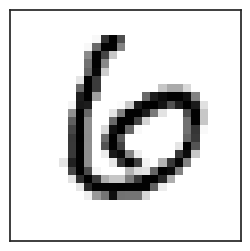

In [6]:
with sns.axes_style("white"):
    plt.figure(figsize=(3,3))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs[11].reshape(28, 28), cmap="gray_r")

The MNIST database contains also labels for images. The label indicates which digit an image is supposed to show. Here is the label for the above image:

In [7]:
labels[11]

6

The picture below shows several MNIST images and their associated labels:

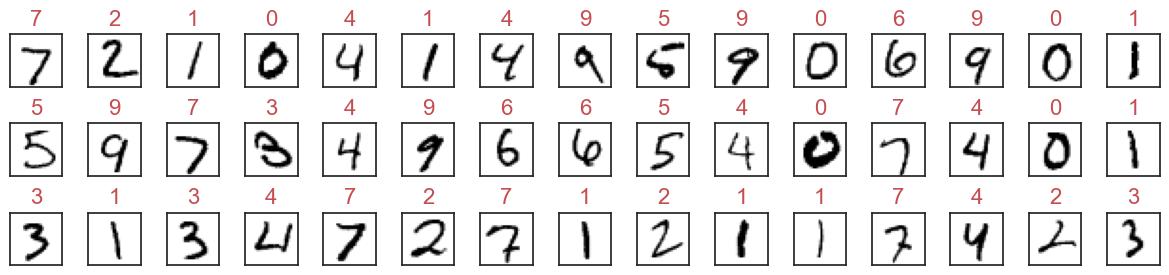

In [8]:
rows = 3
cols = 15
with sns.axes_style("white"):
    plt.figure(figsize=(cols, rows))
    plt.subplots_adjust(hspace=0.7)
    for i in range(45):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(imgs[i].reshape(28,28), cmap="gray_r")
        plt.title(labels[i], c='r', fontdict={"fontsize": 16})
    plt.show()

### Principal axes and principal components of the MNIST data

In order to apply PCA to MNIST images, we will transform these images into a data matrix. Each row of this matrix will correspond to a single image, and entries of a row will give colors of individual pixels of the image. Since an image consists of 28x28=784 pixels, the matrix will have 784 columns.

As a preparation for PCA we demean this data matrix, i.e. we subtract from each columns the mean of this column:

In [9]:
mean_imgs = imgs.mean(axis=0)
A = imgs - mean_imgs

Next, we compute `CA`, the covariance matrix of the demeaned data matrix:

In [10]:
CA = (1/A.shape[0]) * A.T@A

The trace of the covariance matrix gives the total variance of the data matrix:

In [11]:
tot_variance = np.trace(CA)
print(tot_variance)

3215574.9521069997


Next, we compute eigenvalues and eigenvectors of the covariance matrix. The eigenvectors give principal axes of the data matrix. We order the eigenvalues from the largest to the smallest and put the eigenvectors in the same order:

In [12]:
vals, vects = np.linalg.eig(CA)
vals = np.real(vals)
vects = np.real(vects)

# sorting eigenvalues and eigenvectors
ordering = np.argsort(vals)[::-1]
vals = vals[ordering]
vects = vects[:, ordering]

The plot below shows eigenvalues of the covariance matrix from the largest to the smallest. As we can see, a few eigenvalues are very large, but after after the first 100 or so they become much smaller. PCA will let us extract data corresponding to the large eigenvalues and disregard the noisy portion of the data corresponding to small eigenvalues.

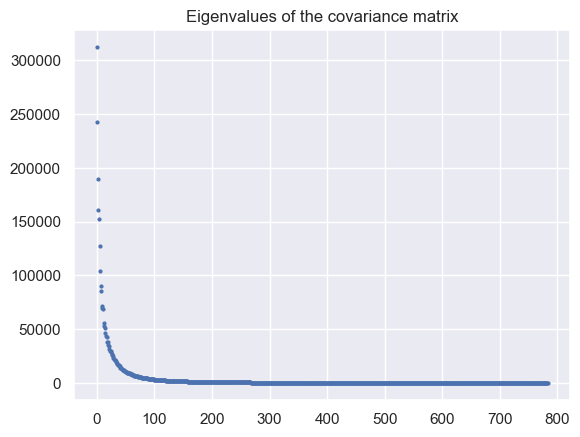

In [13]:
plt.plot(vals, 'b.', ms=4)
plt.title("Eigenvalues of the covariance matrix");

The next plot shows the sum of the first `n` largest eigenvalues divided by the sum of all eigenvalues. This tells us what fraction of the total variance of the data is captured by the first `n` principal components. As we can see we need fewer than 50 principal component to get 80% of the total variance and fewer than 100 
principal components to get to 90%. 

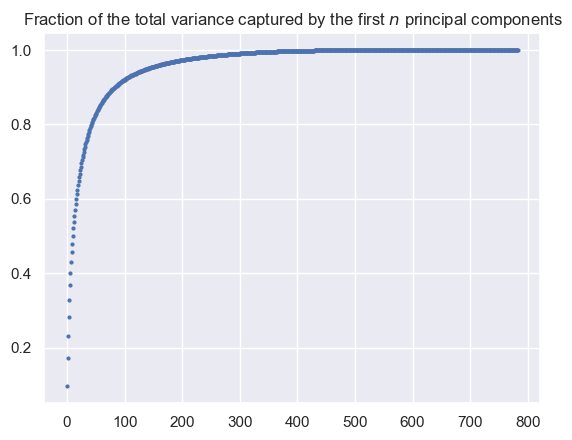

In [14]:
plt.plot(vals.cumsum()/np.trace(CA), 'b.', ms=4)
plt.title("Fraction of the total variance captured by the first $n$ principal components");

Since each eigenvector of the covariance matrix (i.e. each principal axis of the data matrix) has 28x28 coordinates, we can view it as a 28x28 image, with colors of pixels corresponding to values of the coordinates of the eigenvector. In the pictures below red pixels correspond to positive coordinates and blue colors to negative coordinates. Shades of white correspond to coordinates that are close to 0. 

Here is the picture of the eigenvector corresponding to the 5th largest eigenvalue:

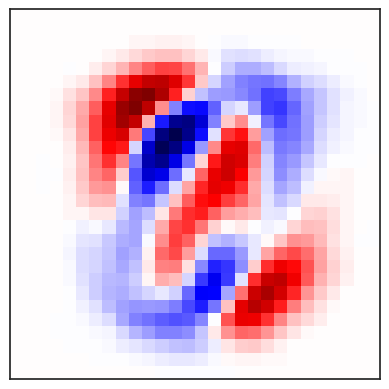

In [15]:
n = 5
from matplotlib import colors

with sns.axes_style("white"):
    divnorm=colors.TwoSlopeNorm(vcenter=0.)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(vects[:, n-1].reshape(28, 28), cmap="seismic", norm=divnorm);

Compare it with the picture of the eigenvector corrsponding to the 500th largets eigenvalue:

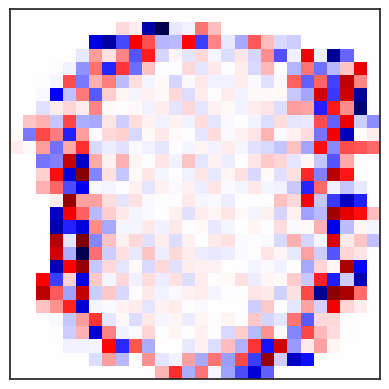

In [16]:
n = 500

with sns.axes_style("white"):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(vects[:, n-1].reshape(28, 28), cmap="seismic", norm=divnorm);

As we can see eigenvectors corresponding to large eigenvalues seem to pick up some features of the images, while eigenvectors corresponding to small eigenvalues seem chaotic and do not have a clear structure. 

Next, we calculate a matrix `P12`. Rows of this matrix are labeled by MNIST images. The matrix has two columns that give the first two principal components of the MNIST data. In this matrix each MNIST image (which originally was described using 28x28=784 numbers) is encoded using only two numbers.

In [17]:
P12 = A@vects[:, :2]
order = np.argsort(labels)
ord_P12 = P12[order]
ord_labels = labels[order]
print(P12)

[[ 279.96771714 -509.4560802 ]
 [   6.07265129 1021.05501932]
 [ 891.54372148  343.08572597]
 ...
 [ 215.00963864  711.10338479]
 [ 149.92712386 -809.43297454]
 [-193.97116288  -39.9147806 ]]


Since each row of the matrix `P12` has two coordinates, we can plot these rows on a 2-dimensional plane. In the plot below each dot represents a single MNIST image. Colors of the dots depend on what digit an image represents.

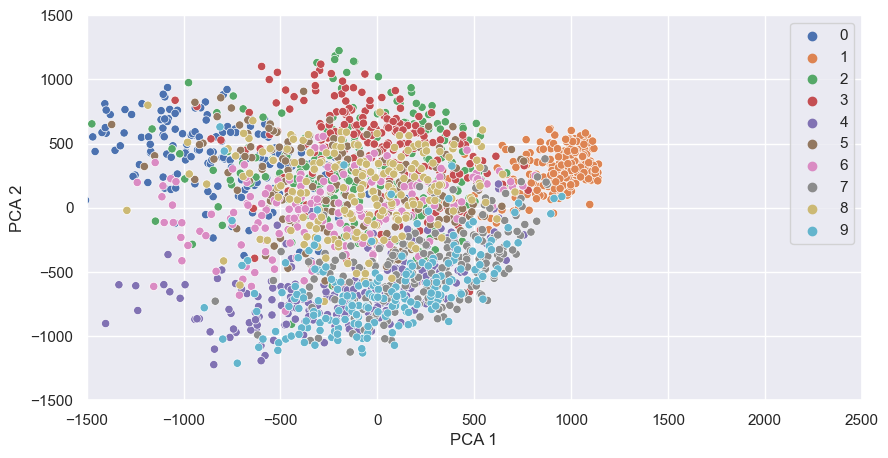

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(x=ord_P12[:, 0], y=ord_P12[:, 1], hue=list(map(str, ord_labels)))
ax.set_xlim([-1500, 2500])
ax.set_ylim([-1500, 1500])
ax.set_ylabel('PCA 2')
ax.set_xlabel('PCA 1')
plt.show()

The above picture shows that even though we reduced each image to just two numbers, i.e. its first two principal components, some types of images seem to be clearly separated from other types. For example, images of the digit 1 (green dots) seem to be clustered together and do not mix too much with other images. This suggests that it should be relatively easy to recognize if an image represents the digit 1 or some other digit. For example, here is a graph showing only only images of digits 1 and 0:



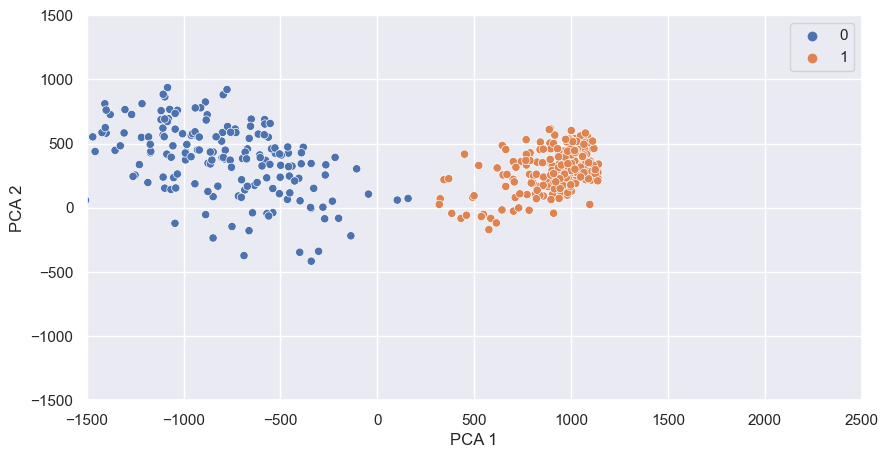

In [19]:
digits = [1, 0]
mask = np.isin(ord_labels, digits)
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(x=ord_P12[mask][:, 0], y=ord_P12[mask][:, 1], hue=list(map(str, ord_labels[mask])))
ax.set_xlim([-1500, 2500])
ax.set_ylim([-1500, 1500])
ax.set_ylabel('PCA 2')
ax.set_xlabel('PCA 1')
plt.show()

Some other types of digits are more intermingled. For example, here is a plot showing images of digits 6 and 8:

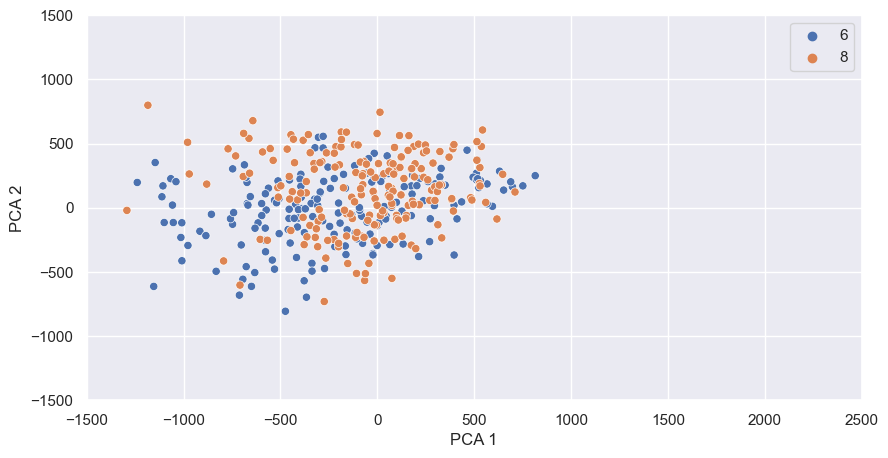

In [20]:
digits = [6, 8]
mask = np.isin(ord_labels, digits)
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(x=ord_P12[mask][:, 0], y=ord_P12[mask][:, 1], hue=list(map(str, ord_labels[mask])))
ax.set_xlim([-1500, 2500])
ax.set_ylim([-1500, 1500])
ax.set_ylabel('PCA 2')
ax.set_xlabel('PCA 1')
plt.show()

This indicates that it is difficult to decide if an image shows the digit 6 or the digit 8 using only the first two principal components of images. Further principal components may been neededfor this task.

### Recontruction of MNIST images

As a final task we try to attempt to reconstruct MNIST images from some number of their principal axes and components. We will check how close these reconstructed images are to the original images.  

In [21]:
#PCA coordinates of images (one image per row)
pca = A@vects

In [22]:
approx_cache = None
n_cache = -1

def compare_pca(k, n):
    global n_cache
    global approx_cache
    if n != n_cache:
        approx  = pca[:, :n]@vects[:, :n].T + mean_imgs[None, ...]
        approx_cache = approx
        n_cache = n
    else: 
        approx = approx_cache
    plt.figure(figsize=(5, 12))
    plt.subplot(121)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs[k].reshape(28,28), cmap="gray_r", vmin=0, vmax=255)
    plt.subplot(122)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"# princ. comp. = {n}")
    plt.imshow(approx[k].reshape(28,28), cmap="gray_r", vmin=0, vmax=255)
    plt.show()

The function `compare_pca` displays an original MNIST image and its reconstruction obtained using some number of principal components. The first argument of the function is the index of an image (i.e. the number of a row of the data matrix). The second argument specifies how many principal components should be used in the image reconstruction:

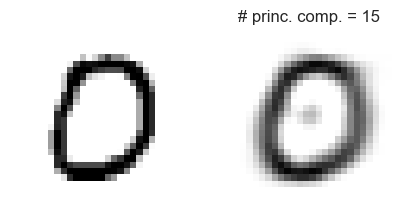

In [23]:
compare_pca(10, 15)

The widget below uses the same function, but has sliders to change images and the number of principal components used for their reconstruction:

In [24]:
from ipywidgets import interact, fixed

interact(compare_pca, 
        k = (0, 100, 1), 
        n = (0, 480, 5), 
        continuous_update=False
        );

interactive(children=(IntSlider(value=50, description='k'), IntSlider(value=240, description='n', max=480, ste…